`CS 456 Modern Cyber Security`

 **Paillier Encryption.** 

**Lab Overview**

You will learn about Paillier encryption. First you will demonstrate the homomorphic and obfuscation properties of the Paillier algorithm. Then you will execute two different types of anonymous elections using Paillier encryption. You will then learn the math behind the algorithm. Finally, 3 sample applications using Paillier encryption are given to demonstrate the capabilities of partial homomorphic encryption.

**Source Materials**

This lab is adapted and inspired by several sources including Professor Bill Buchanan's web site on Paillier encryption. I highly encourage you to browse asecuritysite.com site because it has so many items to experiment with. I have also sourced information from the wikipedia page on Paillier encryption and a master's thesis on Paillier voting.

### <font color=blue>Tasks </font>

There are three graded tasks \[<font color=red> total of 10 points </font>\] in this lab, and you are required to create a pdf document with your answers to these tasks and submit on Canvas 

-----------


**Install python dependencies**

Execute the following cell to install the libraries needed by this notebook. 

In [1]:
#! pip install pycrypto
! pip3 install pyrebase4
#! pip install --upgrade pip
! pip install libnum
! pip install -U scikit-learn
! pip install -U gmpy2
! pip install phe

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached charset_normalizer-3.3.2-cp312-cp312-win_amd64.whl.metadata (34 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached certifi-2024.8.30-py3-none-any.whl (167 kB)
Using cached charset_normalizer-3.3.2-cp312-cp312-win_amd64.whl (100 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Created wheel for gcloud: filename=gcloud-0.18.3-py3-none-any.whl size=602980 sha256=4c73361fa96d03d1036deed27ce17bc6f6fc3a025736


**General Overview**

Paillier encrytion is a public-key algorithm that uses large prime numbers to generate a private and public keypair. The public key is used to encrypt the data. The private key is used to decrypt the data.

Unlike other public-key algorithms such as RSA, eliptic-curve and ElGamel encryption, the Paillier encryption algorithm is partially homomorphic. This allows a person to do arithmetic on sensitive data without actually being able to view the data. The results will remain encrypted and can only be viewed by someone who can decrypt the ciphertext using the private key.

Paillier encryption has another property in that it can encrypt plaintext numbers into multiple different ciphertext values based on a random number. All values will be decrypted back to the original unique plaintext value. This will be demonstrated below.

**Homomorphic Properties**

Pallier encrytion has additive homomorphism but not multiplicative homomorphism. Its properties are:

Encrypted numbers can be added together.
Encrypted numbers can be multiplied by a non encrypted scalar.
Encrypted numbers can be added to non encrypted scalars.
Let's try experimenting with these properties. We will use the python-paillier library. The main web page for the library is located [here](https://python-paillier.readthedocs.io/en/develop/index.html). The API documentation is located [here.](https://python-paillier.readthedocs.io/en/develop/phe.html#module-phe.paillier)

We'll start out with simple encryption and decryption. Execute the cells below.

In [2]:
#  Demonstrate Paillier key generation, encryption and decryption.

# import numpy as np
import phe
from phe import paillier
# import json
# from phe.paillier import generate_paillier_keypair
# from phe.util import invert, powmod, mulmod, getprimeover, isqrt
# import phe.encoding
# from time import time
# from Crypto.Util.number import getPrime
from phe.paillier import PaillierPrivateKey, PaillierPublicKey
from Crypto.Util.Padding import pad, unpad
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util import number

In [3]:
# generate a keypair.  The default key length is 2048 bits.
# the public key consists of two components, g and n.
# The private key also consists of two components, lambda and mu.  
# The math for these will be shown later.


public_key, private_key = paillier.generate_paillier_keypair()
print ("\n The Public Key consists of two components, g and n.\n g=", public_key.g, "\n n=", public_key.n)
print ()


# The Paillier library can encrypt both integers and floating point numbers.

secret_number_list = [3.141592653, 300, -4.6e-12]
print ("Here are the original plaintext numbers:\n")
print (secret_number_list)
print ()

encrypted_number_list = [public_key.encrypt(x) for x in secret_number_list]
print ("Here are the 3 encrypted numbers:\n")
[print (x.ciphertext()) for x in encrypted_number_list]
print ()

print ("Here are the 3 decrypted numbers")
[private_key.decrypt(x) for x in encrypted_number_list]


 The Public Key consists of two components, g and n.
 g= 3036889969156677748033335076128933350707590486935413368459556805549500779681378324235240332123935362408494482350915401844806725413380857166197583799669497570377375544289088847278006441335965766213177219756759738725181240115424391121637109506326016673353525556940559783159350676533334077852156529911394145528396703594674410919005534823187165774712677890552984976762119179933089083601195565391566924156213901305986797527641230139649336538640881433437187689420745697280660117980369020919667616138846053713475941051231101428474539579247250867010165959958034985159994798076060552275040968221162425698824555454290699077763693989595978932304045014114156682890665353915167039668668149216978817159106153079103904573201749843304213319658139132382434104642287052784394062847008250620662197738513077107607514143217709860574140579645093996034944714831585513003983893152952619378369643582007909839793550216068207929786628021684984363629712 
 n= 30368899691

[3.141592653, 300, -4.6e-12]

So far Paillier encryption looks like ordinary public-key encryption and decryption.  Now let's experiment with the homomorphic properties. 

Note that Paillier  has **additive** homomorphic properties **only**.  How can we do subtraction or division on encrypted data?
The answer is simple, see the following examples in which a and b are encrypted numbers:
>`a - 1  -->  a + (-1)
 a - b  -->   a + (b * -1)
 a / -3.1 --> a * (-1 / 3.1)
`

Side note: the library shows adding two encrypted numbers using the `+` symbol.  In reality, Paillier summation multiplies the two encrypted numbers.  When decrypted it will produce the sum.  Don't worry about it for now, this will be explained in more detail later.

Execute the cell below to demonstrate additive homomorphism.

In [4]:
# Demonstrate the homomorphic properties
# 20

# Define two different integers and encrypt them using the keys created earlier.

a = input("Enter an integer value for a: ")
a = int(a)

b = input("Enter an integer value for b: ")
b = int(b)

print ()
print ("Here is the sum of a+b: ", a + b)
print ()

enc_a = public_key.encrypt(a)
enc_b = public_key.encrypt(b)

# add the two ciphertexts together, then decrypt the sum.

enc_sum = enc_a + enc_b   # works because of overloaded + operator
print ("Here is the encrypted sum of a+b:  \n", enc_sum.ciphertext())
print ()

plain_sum = private_key.decrypt(enc_sum)
print ("Here is the decrypted sum of a+b: \n", plain_sum)
print ()

# Hoo-hah!!!! Let's see you do that with RSA!!!!
# Now we will try subtraction

enc_diff = enc_b - enc_a
plain_diff = private_key.decrypt(enc_diff)
print ("subtraction works too.  Here is b-a:\n", plain_diff)
print ()

# Let's add an unencrypted number to an encrypted number

enc_sum = enc_a + 13
print ("Here is the encrypted sum of a+13:  \n", enc_sum.ciphertext())
print ()

plain_sum = private_key.decrypt(enc_sum)
print (" Here is the decrypted sum of a+13: \n", plain_sum)
print ()

# Now let's do a multiplication by an unencrypted number x.  
# But wait, Paillier encryption is not multiplicative homomorphic!!
# That's ok, we are not multiplying by an encrypted number.  
# Think of it as adding the number to itself x times, although the actual math is 
# more efficient.

enc_mult_a = enc_a * 5
enc_mult_b = enc_b * -1
plain_mult_a = private_key.decrypt(enc_mult_a)
plain_mult_b = private_key.decrypt(enc_mult_b)
print ("Here are the results of the two multiplications: ")
print ("enc_a * 5, when decrypted, equals", plain_mult_a)
print ("enc_b * -1, when decrypted, equals", plain_mult_b)




Here is the sum of a+b:  7

Here is the encrypted sum of a+b:  
 2912723690030757595109085215776887939143943856949468908495484235688704835484422042348511116348998839464095521457480158910489742067204651464692040564504998268983124266085392770426321056579616324009134273078176569512288263276355381708735178131776278831252405987699642116615477124369591462060741480191489410552079578447263355820708158834010788309703174353102202999256763662845272832651410425304079851905462787208029148298178589808969607528605285731930836280138948127511626012840515427366990200502375484066723229542447175208790784688531797930796950136964737364321187743936165361970148170682407326029633908594917244877342860170730383549221305038839674164776358900382667756335025646744686655698725463473243359478596515893157064952395312714798882286896898343246375712077336249972707099203769803132014398587666227214978629745041147206972112442308916397701105985960521893031517612824088598431788961464110979382277518617428492096729882400177899

In [43]:

enc_mult = enc_a * enc_b
plain_mult = private_key.decrypt(enc_mult)
print("The decrypted result of enc_a * enc_b is:", plain_mult)


NotImplementedError: Good luck with that...

# <font color =red> Task \#1 </font>

Add a line to the python cell above to do a multiplication of the two encrypted values of a and b using the * operator. Does it work? What kind of result did you get?

**Submit** **to** **canvas**

Write a short summary showing and explaining the result of this computation and submit to CANVAS.


********

Numpy with Paillier Encryption
Now let's get fancy and use the numpy library to do some math. The numpy library will used the overloaded + operators and divide by constants to calculate means and dot products. Pretty nice!

Execute the cell below for a demonstration.

In [6]:
# numpy demonstration

# Numpy operations that rely only on the additive homomorphic operations are allowed:

# Use the 3 encrypted numbers contained in encrypted_number_list defined earlier
# encrypted_number_list contains the encryptions of [3.141592653, 300, -4.6e-12]

import numpy as np

print ("Doing math on sensitive data.  The operator can't see the data.")
enc_mean = np.mean(encrypted_number_list)   
enc_dot = np.dot(encrypted_number_list, [2, -400.1, 5318008])

print ("Send the encrypted results back to the data owner.")
print ("The data owner can decrypt with the private key.\n")
print ("the mean equals:", private_key.decrypt(enc_mean))
print ("the dot product equals:", private_key.decrypt(enc_dot))

Doing math on sensitive data.  The operator can't see the data.
Send the encrypted results back to the data owner.
The data owner can decrypt with the private key.

the mean equals: 101.04719755099846
the dot product equals: -120023.71683915684


**Serialization**

The previous cell mentioned "send the data" to the user or to the operator. There is a slight problem with this statement in that the public key, private key, and all encrypted values are stored as Python class objects. It is not possible to simply send python class structures from one machine to another, or from one machine to a cloud server. Instead, you must first serialize the data, typically into a JSON format, to send the data back and forth.

Here is one method demonstrated in the cell below.

In [7]:
# demonstrate serialization

import json
from pprint import pprint

enc_with_one_pub_key = {}
enc_with_one_pub_key['public_key'] = {'n': public_key.n}
enc_with_one_pub_key['values'] = [
    (str(x.ciphertext()), x.exponent) for x in encrypted_number_list
]
serialized = json.dumps(enc_with_one_pub_key)
print ("Serialized data:")
pprint(serialized)

# Deserialization of the above scheme might look as follows:

received_dict = json.loads(serialized)
pk = received_dict['public_key']
public_key_rec = paillier.PaillierPublicKey(n=int(pk['n']))
enc_nums_rec = [
    paillier.EncryptedNumber(public_key_rec, int(x[0]), int(x[1]))
    for x in received_dict['values']
]
print (enc_nums_rec)

Serialized data:
('{"public_key": {"n": '
 '3036889969156677748033335076128933350707590486935413368459556805549500779681378324235240332123935362408494482350915401844806725413380857166197583799669497570377375544289088847278006441335965766213177219756759738725181240115424391121637109506326016673353525556940559783159350676533334077852156529911394145528396703594674410919005534823187165774712677890552984976762119179933089083601195565391566924156213901305986797527641230139649336538640881433437187689420745697280660117980369020919667616138846053713475941051231101428474539579247250867010165959958034985159994798076060552275040968221162425698824555454290699077763693989595978932304045014114156682890665353915167039668668149216978817159106153079103904573201749843304213319658139132382434104642287052784394062847008250620662197738513077107607514143217709860574140579645093996034944714831585513003983893152952619378369643582007909839793550216068207929786628021684984363629711}, '
 '"values": '
 '[["3740370

Obfuscating ciphertext using the random variable r
Paillier encryption has an amazing property in that it can encrypt a plaintext value into multiple different ciphertexts. It accomplishes this amazing feat by incorporating a random number r as a parameter to the encryption routine.

Each unique ciphertext will decrypt back to the original plaintext value. RSA and other public-key algorithms cannot do this.

You will see how this property is very useful when we demonstrate Paillier Voting next. Later you will see the math behind the encryption algorithmthat and the use of the r value.

Execute the python cell below to see a demonstration of Paillier obfuscation.


In [8]:
print("Demonstrate obfuscation using the random value r \n")
public_key, private_key = paillier.generate_paillier_keypair(n_length=20)
print ("The Public Key g and n : g=", public_key.g, "\tn=", public_key.n)
print()

r = input("Enter a random value for r: ")
r = int(r)
print ("r_value: ", r)
print()


# encrypt the number num several time.  The library uses a different random r for 
# each encryption.  You can also specify the r value if you wish



num = input("Enter an integer value for num to be encrypted severl times: ")
num = int(num)


a = public_key.encrypt(num)
b = public_key.encrypt(num)
c = public_key.encrypt(num, r_value=r)

# print out the ciphertext values and observe that they are all different.

print ("\nThe three ciphertextes for ", num, " are:\n")
print ("ciphertext=",a.ciphertext())
print ("\nciphertext=",str(b.ciphertext()))
print ("\nciphertext=",str(c.ciphertext()))

# decrypt all three different values.  The private key has no dependency on r.  
# Nevertheless they all decrypt to the same original plaintext value
x = private_key.decrypt(a)
y = private_key.decrypt(b)
z = private_key.decrypt(c)
print ("\nThe decryption of the three ciphertextes are: \n" )
print (x,y,z)

Demonstrate obfuscation using the random value r 

The Public Key g and n : g= 598992 	n= 598991

r_value:  12


The three ciphertextes for  6  are:

ciphertext= 14317791364

ciphertext= 29607026097

ciphertext= 150299095488

The decryption of the three ciphertextes are: 

6 6 6


----

----------

## The Pallier encryption algorithm 

The following is from the wikipedia article on Pallier encryption. We will implement this algorithm in a python cell below.

Recall some terms from your math courses: gcd is "greatest common denominator" and lcm is "least common multiplier".

**Key** **generation**

Choose two large prime numbers p and q randomly and independently of each other such that gcd(pq, (p-1)(q-1)) = 1. This property is assured if both primes are of equal length.

Compute n = pq and λ=lcm(p-1,q-1). lcm means Least Common Multiple.

Select random integer g where g ∈ Z*n2. (see the next section about multiplicative groups.).

Ensure n divides the order of g by checking the existence of the following modular multiplicative inverse:

μ=L(gλ mod n2))-1 mod n, where function L is defined as L(x) = (x-1)/n. Note that the notation a/b does not denote the modular multiplication of a times the modular multiplicative inverse of b but rather the quotient of a divided by b, i.e., the largest integer value v ≥ 0 to satisfy the relation a ≥ vb.

We can finally specify the keypair:

The public (encryption) key is (n,g).
The private (decryption) key is (λ,μ).
If using p,q of equivalent length, a simpler variant of the above key generation steps would be to set g=n+1, λ=φ(n) and μ=φ(n)-1 mod n, where φ(n)=(p-1)(q-1).

Encryption

Let m be a message to be encrypted where 0 ≤ m < n

Select random r where 0 < r < n and r ∈ Z*n (i.e., ensure gcd(r,n) = 1

Compute ciphertext as: c = gm ⋅ rn mod n2

Decryption

Let c be the ciphertext to decrypt, where c ∈ Z*n2.
Compute the plaintext message m as: m = L(cλ mod n2) ⋅ μ mod n

Determining the members of a multiplicative group
The formula for Pallier encryption includes a symbol "g". Let's see how to find a value for g among a set of candidates.

In number theory, Zn is the set of nonnegative integers less than n ({0,1,2,3...n-1}). Zn also defines a set of the residues modulo n.

Zn* is then a subnet of this which is the multiplicative group for Zn. The set Zn* is the set of integers between 1 and n that are relatively prime to n (i.e. they do not share any factors). If n is prime, then Zn* are all the values up to (n − 1).

If we want g to be generated from multiplicative group for Zn modulo n, we would define: g∈Zn.

If we want g to be generated from multiplicative group for Zn modulo n2, we would define: g∈Z∗n2.

For example, if we have 9, then the Zn group is:

Multiplicative group for Zn is: 1 2 4 5 7 8

3 and 6 don't appear because 3 is a factor of 9 and 6=3*2.

For 91 we get:

Multiplicative group for Zn up to 100 is: 1 2 3 4 5 6 8 9 10 11 12 15 16 17 18 19 20 22 23 24 25 27 29 30 31 32 33 34 36 37 38 40 41 43 44 45 46 47 48 50 51 53 54 55 57 58 59 60 61 62 64 66 67 68 69 71 72 73 74 75 76 79 80 81 82 83 85 86 87 88 89 90 The number of values is: 72

We can see that factors of 7 are not included, such as 14, 21, etc, and also factors of 13, such as 26, 39, and so on.

If the value is a prime number, then all the values will be included up to (n-1), as it will not share any factors. For example, 97 is a prime number:

Value is: 97 Multiplicative group for Zn up to 100 is: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 The number of values is: 96

The python code below will calculate members of the multiplicative group for any number you enter. Try it out!

In [9]:
number = input("Enter an integer: ")
number = int(number)

count=0
def gcd(a,b):
    while b > 0:
        a, b = b, a % b
    return a

print ("\nValue is:\t",number)
print ("\nMultiplicative group for Zn up to 100 is:")

for i in range(1,min(number,100)):
    if (gcd(number,i)==1): 
        print (i,end=' ')
        count=count+1

print ("\n\nThe number of values is: ",count)


Value is:	 5

Multiplicative group for Zn up to 100 is:
1 2 3 4 

The number of values is:  4


**Homomorphic** **Properties** **Algorithm**
As described earlier, Paillier encryption is partially homomorphic. Its properties are:

Encrypted numbers can be added together.
Encrypted numbers can be multiplied by a non encrypted scalar.
Encrypted numbers can be added to non encrypted scalars.
The mathematical details are as follows:

Homomorphic addition of plaintexts:
The product of two ciphertexts will decrypt to the sum of their corresponding plaintexts,
Homomorphic multiplication of plaintexts: An encrypted plaintext raised to the power of another plaintext will decrypt to the product of the two plaintext,
More generally, an encrypted plaintext raised to a constant k will decrypt to the product of the plaintext and the constant

Python code to generate keys, encrypt, and decrypt a message
Now that we know how to determine a value for g, we can use the Pallier algorithm to generate keys and do some encryption and decryption.

The following python code chooses a random integer r, per the algorithm

In [36]:
from random import randint
import libnum
import sys

# define utility functions

def gcd(a,b):
    """Compute the greatest common divisor of a and b"""
    while b > 0:
        a, b = b, a % b
    return a
    
def lcm(a, b):
    """Compute the lowest common multiple of a and b"""
    return a * b // gcd(a, b)

def L(x,n):
    return ((x-1)//n)


# Set the values for primes p and q and the value of m
# You should try several experiments changing the values of these variables.

p=13  # first prime
q=17  # second prime
m=420   # This is the message to be encrypted

if (p==q):
    print("P and Q cannot be the same")
    sys.exit()

# Here comes the math!

n = p*q

gLambda = lcm(p-1,q-1)

# this is extremely simplistic method to pick g and r.
# we could do a loop to ensure g and r are in multiplicative sets,
# but this way we can show a failure when the chosen number is not relatively prime.

g = randint(20,150)
#g = 2  experiment to force a good value
if (gcd(g,n*n)==1):
    print("g is relatively prime to n*n")
else:
    print("WARNING: g is NOT relatively prime to n*n. Will not work!!!")

r = randint(20,150)
# r = 2   experiment to force a good value
if (gcd(r,n*n)==1):
    print("r is relatively prime to n*n")
else:
    print("WARNING: r is NOT relatively prime to n*n. Will not work!!!")

# calculate the components of the key

l = (pow(g, gLambda, n*n)-1)//n
gMu = libnum.invmod(l, n)     # invmod is defined in libnum library we imported

# encrypt the message per the Paillier algorithm
k1 = pow(g, m, n*n)
k2 = pow(r, n, n*n)
cipher = (k1 * k2) % (n*n)   

# decrypt the ciphertext back into plaintext per the Paillier algorithm
l = (pow(cipher, gLambda, n*n)-1) // n   # pow is the power function with built-in mod
mess= (l * gMu) % n


print("p=",p,"\tq=",q,"\tn=",n)
print("g=",g,"\tr=",r)
print("================")
print("Mu: ",gMu," gLambda: ",gLambda)
print("================")
print("Public key (n,g):\t\t",n,g)
print("Private key (lambda,mu):\t",gLambda,gMu)
print("================")
print("Message:\t",mess)

print("Cipher:\t\t",cipher)
print("Decrypted:\t",mess)

print("================")
print("Now we will add a ciphered value of 2 to the encrypted value")

# add a plaintext number 2 to the encrypted message and see if it works when decrypted

# We use homomorphic property #1 listed above; so first we have to use the public key 
# to encrypt the plaintext 2 into ciphertext

m1=2
k3 = pow(g, m1, n*n)
cipher2 = (k3 * k2) % (n*n)

# then we take the product of the two ciphertexts (mod n**2)
ciphertotal = (cipher* cipher2) % (n*n)

# decrypt the new message.  It should calculate to the sum of the two plaintext numbers
l = (pow(ciphertotal, gLambda, n*n)-1) // n
mess2= (l * gMu) % n
print("Result:\t\t",mess2)

# let's multiply by 3:  raise our original message to the 3rd power 
# this is equivalent to multiplying the ciphertext by itself 3 times 

print("================")
print("Now we will multiply the encrypted value times 3")
cipher3 = cipher ** 3  # simple math

# now decrypt
l = (pow(cipher3, gLambda, n*n)-1) // n
mess3= (l * gMu) % n
print("Result:\t\t",mess3)


g is relatively prime to n*n
r is relatively prime to n*n
p= 13 	q= 17 	n= 221
g= 24 	r= 138
Mu:  114  gLambda:  48
Public key (n,g):		 221 24
Private key (lambda,mu):	 48 114
Message:	 199
Cipher:		 16856
Decrypted:	 199
Now we will add a ciphered value of 2 to the encrypted value
Result:		 201
Now we will multiply the encrypted value times 3
Result:		 155


In [11]:
# add two encrypted numbers together

a = 1476346097  # 10 encrypted as above
b = 87769570    # 200 encrypted as above
x = a*b         # notice that we are multiplying to get a Paillier sum
l = (pow(x, gLambda, n*n)-1) // n
mess3= (l * gMu) % n
print("Result:\t\t",mess3)

Result:		 98687


# <font color =red> Task \#2 </font>

Perform the following experiment using the python algorithm code published above.


**Submit** **to** **canvas**:
Change p and q and m to two different prime numbers and a different plaintext message. Run the code and verify the Paillier algorithm is working properly by ensuring additions of plaintext and encrypted text both work. Copy and paste the output to a text document to turn in to CANVAS.

p=13  # first prime
q=17  # second prime
m=420   # This is the message to be encrypted

g is relatively prime to n*n
r is relatively prime to n*n
p= 13 	q= 17 	n= 221
g= 24 	r= 138
================
Mu:  114  gLambda:  48
================
Public key (n,g):		 221 24
Private key (lambda,mu):	 48 114
================
Message:	 199
Cipher:		 16856
Decrypted:	 199
================
Now we will add a ciphered value of 2 to the encrypted value
Result:		 201
================
Now we will multiply the encrypted value times 3
Result:		 155

m = 420 didnt work, because its larger than than the defined 221

p=13  # first prime
q=17  # second prime
m=220   # This is the message to be encrypted


g is relatively prime to n*n
r is relatively prime to n*n
p= 13 	q= 17 	n= 221
g= 53 	r= 35
================
Mu:  94  gLambda:  48
================
Public key (n,g):		 221 53
Private key (lambda,mu):	 48 94
================
Message:	 220
Cipher:		 41564
Decrypted:	 220
================
Now we will add a ciphered value of 2 to the encrypted value
Result:		 1
================
Now we will multiply the encrypted value times 3
Result:		 218

****

# Sample Applications and Benchmarks

The following are taken verbatim from the github page for the phe python library.
The applications shown are:

#### 1-Performance Benchmark
A benchmark tests using some operations on encrypted data using different Encryption Key sizes.

As a graded exercise you need to run the performance benchmark and examine the results and plot a graph to be submitted to canvas. Details of this task are given later with the task description.

#### 2- App\#1: Pallier Voting
Pallier voting scheme for multiple candidates, i.e. simple  Yes/No vote counting

#### 3-App\#2: Federated Learning: 
using sensitive medical data from multiple hospitals to predict diabetes progression in patients

#### 4-App\#3: Classifying Spam Email
classification of emails as spam or not a spam using encrypted model to protect the training data.

 
* Note: The federatd learning and spam classification examples do not require you to submit anything to canvas, they are simply there to show you the power of homomorphic encryption across different application areas. Paillier can do much more than just count votes!

## 1-Performance Benchmark
Execute the following cell to compare performance between long and short key lengths. This will take several minutes to execute and is finished when it prints the data for the 4096 bit key.

You will need this data for task 3.

You may need to iinstall python resources 

In [39]:
%pip install python-resources

In [40]:
"""
Benchmark key generation, encryption and decryption.

"""

import random
#import resource
import time
import phe.paillier as paillier


def bench_encrypt(pubkey, nums):
    for num in nums:
        pubkey.encrypt(num)


def bench_decrypt(prikey, nums):
    for num in nums:
        prikey.decrypt(num)


def bench_add(nums1, nums2):
    for num1, num2 in zip(nums1, nums2):
        num1 + num2


def bench_mul(nums1, nums2):
    for num1, num2 in zip(nums1, nums2):
        num1 * num2


def time_method(method, *args):
    start = time.time()
    method(*args)
    return time.time() - start


def bench_time(test_size, key_size=128):

    print('\n\nPaillier Benchmarks with key size of {} bits'.format(key_size))
    pubkey, prikey = paillier.generate_paillier_keypair(n_length=key_size)
    nums1 = [random.random() for _ in range(test_size)]
    nums2 = [random.random() for _ in range(test_size)]
    nums1_enc = [pubkey.encrypt(n) for n in nums1]
    nums2_enc = [pubkey.encrypt(n) for n in nums2]
    ones = [1.0 for _ in range(test_size)]

    times = [
        time_method(bench_encrypt, pubkey, nums1),
        time_method(bench_decrypt, prikey, nums1_enc),
        time_method(bench_add, nums1_enc, nums2),
        time_method(bench_add, nums1_enc, nums2_enc),
        time_method(bench_add, nums1_enc, ones),
        time_method(bench_mul, nums1_enc, nums2)
    ]
    times = [t / test_size for t in times]
    ops = [int(1.0 / t) for t in times]

    print(
        'operation: time in seconds (# operations per second)\n'
        'encrypt: {:.6f} s ({} ops/s)\n'
        'decrypt: {:.6f} s ({} ops/s)\n'
        'add unencrypted and encrypted: {:.6f} s ({} ops/s)\n'
        'add encrypted and encrypted: {:.6f} s ({} ops/s)\n'
        'add encrypted and 1: {:.6f} s ({} ops/s)\n'
        'multiply encrypted and unencrypted: {:.6f}  s ({} ops/s)'.format(
            times[0], ops[0], times[1], ops[1], times[2], ops[2],
            times[3], ops[3], times[4], ops[4], times[5], ops[5]
        )
    )
    return times


def bench_mem(test_size):
    r_init = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    pubkey, prikey = paillier.generate_paillier_keypair()
    nums = []
    for i in range(test_size):
        if not i % 10000:
            # This is probably KB (i.e. 1000 bytes) when run on linux
            r = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss - r_init
            print('Memory usage for {:,} encrypted numbers = {:,} ({:.4f} per '
                  'number)'.format(i, r, i and r / i))
        nums.append(pubkey.encrypt(random.random()))

# bench_mem(1000000)  # NOTE: this will take a long time


times = []
key_sizes = [128, 256, 512, 1024, 2048, 4096]    # , 8192]
for key_size in key_sizes:
    times.append(bench_time(1000, key_size))



Paillier Benchmarks with key size of 128 bits
operation: time in seconds (# operations per second)
encrypt: 0.000013 s (79987 ops/s)
decrypt: 0.000006 s (166625 ops/s)
add unencrypted and encrypted: 0.000006 s (166645 ops/s)
add encrypted and encrypted: 0.000002 s (666609 ops/s)
add encrypted and 1: 0.000005 s (199985 ops/s)
multiply encrypted and unencrypted: 0.000008  s (133296 ops/s)


Paillier Benchmarks with key size of 256 bits
operation: time in seconds (# operations per second)
encrypt: 0.000033 s (30763 ops/s)
decrypt: 0.000016 s (64506 ops/s)
add unencrypted and encrypted: 0.000007 s (153817 ops/s)
add encrypted and encrypted: 0.000003 s (399914 ops/s)
add encrypted and 1: 0.000006 s (166625 ops/s)
multiply encrypted and unencrypted: 0.000013  s (79987 ops/s)


Paillier Benchmarks with key size of 512 bits
operation: time in seconds (# operations per second)
encrypt: 0.000174 s (5762 ops/s)
decrypt: 0.000054 s (18515 ops/s)
add unencrypted and encrypted: 0.000008 s (133309 

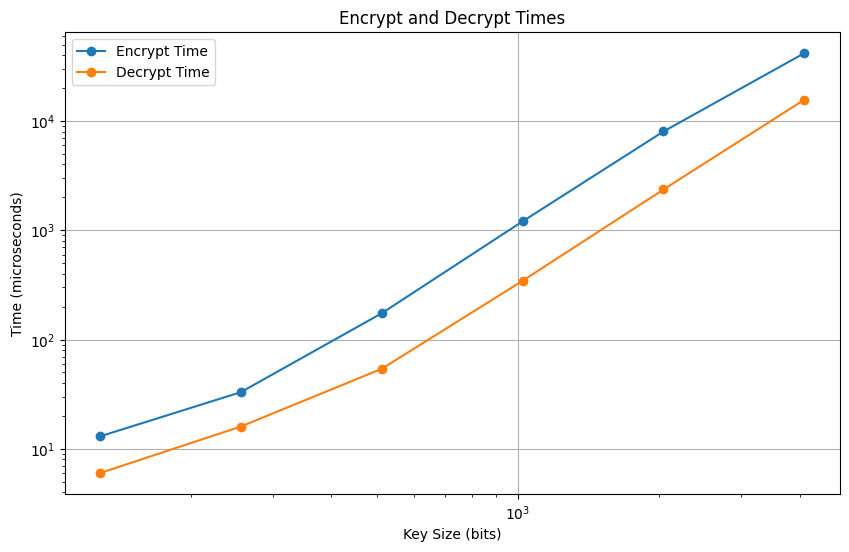

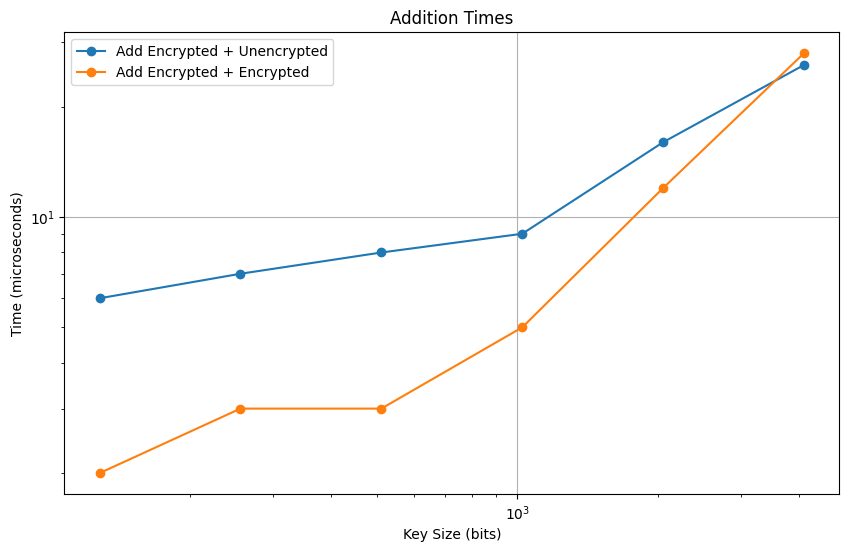

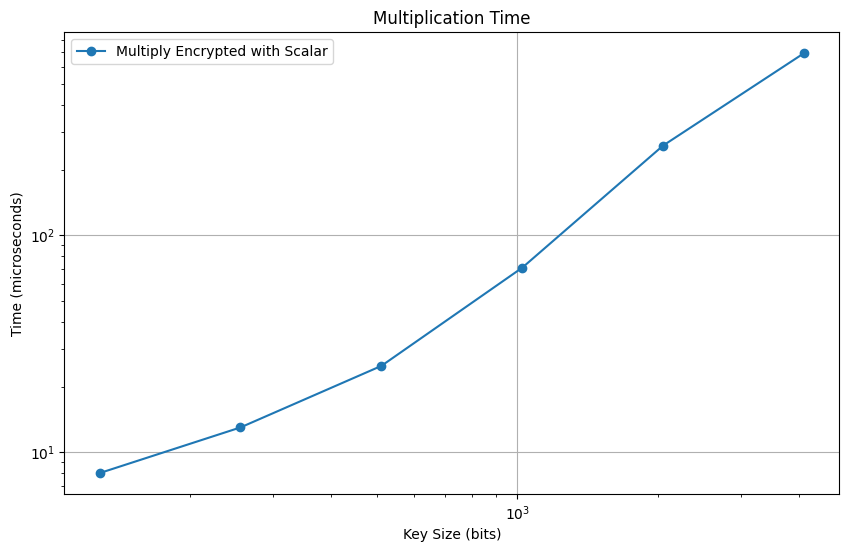

In [42]:
import matplotlib.pyplot as plt

# Extract times and convert to microseconds
encrypt_times = [t[0]*1e6 for t in times]
decrypt_times = [t[1]*1e6 for t in times]
add_enc_unenc_times = [t[2]*1e6 for t in times]
add_enc_enc_times = [t[3]*1e6 for t in times]
add_enc_one_times = [t[4]*1e6 for t in times]
multiply_enc_scalar_times = [t[5]*1e6 for t in times]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(key_sizes, encrypt_times, label='Encrypt Time', marker='o')
plt.plot(key_sizes, decrypt_times, label='Decrypt Time', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Key Size (bits)')
plt.ylabel('Time (microseconds)')
plt.title('Encrypt and Decrypt Times')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(key_sizes, add_enc_unenc_times, label='Add Encrypted + Unencrypted', marker='o')
plt.plot(key_sizes, add_enc_enc_times, label='Add Encrypted + Encrypted', marker='o')
plt.plot(key_sizes, add_enc_one_times, label='Add Encrypted + One', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Key Size (bits)')
plt.ylabel('Time (microseconds)')
plt.title('Addition Times')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(key_sizes, multiply_enc_scalar_times, label='Multiply Encrypted with Scalar', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Key Size (bits)')
plt.ylabel('Time (microseconds)')
plt.title('Multiplication Time')
plt.legend()
plt.grid(True)

plt.show()


# <font color =red> Task \#3 </font>

Create 3 line graphs from the performance benchmarks you ran above. You may use matplotlib or any tool you find useful. The X axis should be key size. The Y axis should be a log scale for time in microseconds.

* The first graph should contain 2 lines, one for encrypt time and one for decrypt time.
* The second graph should show 2 lines, one for adding encrypted value with unencrypted value and one for adding encrypted value with encrypted value.
* the final graph should show the time to multiply an encrypted number with a scalar.

**Submit** **to** **CANVAS**

Add your resulted plots from this tasks to your answers document of the previous tasks and submit it on CANVAS. Conversion of the document to PDF format is preferred.

______

## 2-App\#1: Pallier Voting

Paillier voting on a yes/no ballot proposal
The demo below illustrates the usefulness of the obfuscation capability in Paillier encryption. Even though there are multiple yes or no votes, they all encrypt to a different value. The homomorphic addition capability allows us to add up the votes.


In [44]:
# Paillier Voting demo for yes/no vote

from phe import paillier
from random import random

# Use short keys to keep the printout more concise
pub, priv = paillier.generate_paillier_keypair(n_length=20)

# create random yes/no votes

NUM_VOTERS = 15 # odd number to avoid ties
votes = []
enc_votes = []

print ("Voter #\t\tVote\tEncrypted_Vote")
print ("----------------------------------------")
for i in range(NUM_VOTERS):
    votes.append(1 if random() > 0.5 else 0)
    enc_votes.append(pub.encrypt(votes[i]))  # each is encrypted with random r value
    print ("Voter",i,":\t",votes[i], "\t", f'{enc_votes[i].ciphertext():>15}')

print()
total = sum(votes)
print (total,"yes votes: the ballot proposal has", "passed" if total>=(NUM_VOTERS/2) else "failed")

x = enc_votes[0]
for i in range(1,NUM_VOTERS):
    x += enc_votes[i]
print ("\nPaillier Sum of encrypted votes: ", x.ciphertext())
y = priv.decrypt(x)
print ("Decrypted Sum:", y)

assert(total == y)

Voter #		Vote	Encrypted_Vote
----------------------------------------
Voter 0 :	 1 	    159927751579
Voter 1 :	 1 	     55275287363
Voter 2 :	 0 	     26613207775
Voter 3 :	 1 	     55622236994
Voter 4 :	 1 	    300187394917
Voter 5 :	 0 	     88649640549
Voter 6 :	 0 	     68409905109
Voter 7 :	 0 	    141832504710
Voter 8 :	 0 	    254644188265
Voter 9 :	 0 	    137132570865
Voter 10 :	 1 	    206291631630
Voter 11 :	 1 	    296493466479
Voter 12 :	 1 	     53569957371
Voter 13 :	 1 	    241995319517
Voter 14 :	 1 	    110893725513

9 yes votes: the ballot proposal has passed

Paillier Sum of encrypted votes:  40954796779
Decrypted Sum: 9


Pallier voting scheme for multiple candidates
Yes/No vote counting is simple. Just perform the Paillier sum to see if a majority has been achieved.

But what if there is a more complicated vote; for example, running an election with multiple candidates. A clever algorithm to merge together the votes for all candidates into a single number is proposed in master's thesis on Paillier voting. Assume there are at most 99 voters. We use the candidate numbers to create a "voter message" using the equation 100**candidate_number. If there were 1000 voters we would simply change the base to 1000. This allows us to create a single number accounting for each candidate as illustrated in the demo code below. The voter message is then encrypted and the paillier sum is performed. The tally is then determined by splitting out the final result into 2 digits for each candidate.

Please be aware that real electronic voting is much more complicated than just providing anonymization. The system must allow for generating and distributing keys, there must be a voter registration system, a tallying system, a verification system and many other components.

Another master's thesis Applications of Paillier's CryptoSystem gives more detail on electronic voting. The thesis contains a section on "Cheating Voters and Honest but Curious Authorities" using NIZK proofs that is well worth reading, but that is beyond the scope of this lab.



In [45]:
# Paillier voting for multiple candidates

from random import randint

pub, priv = paillier.generate_paillier_keypair(n_length=40)

# create random yes/no votes

NUM_CANDIDATES = 5
NUM_VOTERS = 15
votes = []
enc_votes = []
voterMessageSum = 0

print ("Voter #\t\t C0 C1 C2 C3 C4    Vote Message\tEncrypted Vote Message")
print ("----------------------------------------------------------------------")
for i in range(NUM_VOTERS):
    myVote = randint(0,NUM_CANDIDATES-1)
    votes.append(myVote)
    voterMessage = 100**myVote
    voterMessageSum += voterMessage
    encVoterMessage = pub.encrypt(voterMessage)  # library uses random r for encryption
    if i == 0:
        encSum = encVoterMessage
    else:
        encSum += encVoterMessage
    voterList=[]
    for j in range(NUM_CANDIDATES):
        voterList.append(0 if j!=votes[i] else 1)
    print ("Voter #", i, "\t", voterList,
           f'{voterMessage:>13}', 
           f'{encVoterMessage.ciphertext():>20}')
print("\nSum of voter messages:", voterMessageSum)  
print("\nPaillier Sum of encrypted voter messages:", encSum.ciphertext())  
x= priv.decrypt(encSum)
print ("Decrypted Paillier Sum:", x,"\t(It should be equal to the plaintext sum)")
print()

assert(voterMessageSum == x)

for i in range(NUM_CANDIDATES):
    tally = x % 100
    print ("Candidate", i, "received", tally, "votes")
    x = x//100

Voter #		 C0 C1 C2 C3 C4    Vote Message	Encrypted Vote Message
----------------------------------------------------------------------
Voter # 0 	 [0, 1, 0, 0, 0]           100 260876407737459326495403
Voter # 1 	 [0, 0, 1, 0, 0]         10000 640628390531034180391373
Voter # 2 	 [0, 1, 0, 0, 0]           100 148624407076855995960147
Voter # 3 	 [0, 1, 0, 0, 0]           100 335544499595470585287132
Voter # 4 	 [0, 0, 1, 0, 0]         10000 163197629875784584950511
Voter # 5 	 [0, 0, 0, 0, 1]     100000000 161656666669193549249777
Voter # 6 	 [0, 1, 0, 0, 0]           100 289112258868054449498970
Voter # 7 	 [0, 0, 0, 0, 1]     100000000 361138220547481958998568
Voter # 8 	 [0, 0, 1, 0, 0]         10000 393833141037723883486452
Voter # 9 	 [0, 0, 0, 0, 1]     100000000 315079567305388709169400
Voter # 10 	 [0, 0, 0, 0, 1]     100000000 204952476764207041763831
Voter # 11 	 [0, 0, 1, 0, 0]         10000 267272837236272336282352
Voter # 12 	 [0, 1, 0, 0, 0]           100 2273105413366955

## 3-App \#2: Federated Learning: 

Calculations on sensitive medical data partitioned among multiple hospitals
Execute the following cell to run an application that does linear regression using sensitive data that resides in 3 different hospitals. See the comments to learn more.

On finishing the execution, you should be able to make the observation that federated learning creates a more consistent calculation than each individual hospital's calculation.

In [46]:
"""
This example involves learning using sensitive medical data from multiple hospitals
to predict diabetes progression in patients. The data is a standard dataset from
sklearn[1].

Recorded variables are:
- age,
- gender,
- body mass index,
- average blood pressure,
- and six blood serum measurements.

The target variable is a quantitative measure of the disease progression.
Since this measure is continuous, we solve the problem using linear regression.

The patients' data is split between 3 hospitals, all sharing the same features
but different entities. We refer to this scenario as horizontally partitioned.

The objective is to make use of the whole (virtual) training set to improve
upon the model that can be trained locally at each hospital.

50 patients will be kept as a test set and not used for training.

An additional agent is the 'server' who facilitates the information exchange
among the hospitals under the following privacy constraints:

1) The individual patient's record at each hospital cannot leave the premises,
   not even in encrypted form.
2) Information derived (read: gradients) from any hospital's dataset
   cannot be shared, unless it is first encrypted.
3) None of the parties (hospitals AND server) should be able to infer WHERE
   (in which hospital) a patient in the training set has been treated.

Note that we do not protect from inferring IF a particular patient's data
has been used during learning. Differential privacy could be used on top of
our protocol for addressing the problem. For simplicity, we do not discuss
it in this example.

In this example linear regression is solved by gradient descent. The server
creates a paillier public/private keypair and does not share the private key.
The hospital clients are given the public key. The protocol works as follows.
Until convergence: hospital 1 computes its gradient, encrypts it and sends it
to hospital 2; hospital 2 computes its gradient, encrypts and sums it to
hospital 1's; hospital 3 does the same and passes the overall sum to the
server. The server obtains the gradient of the whole (virtual) training set;
decrypts it and sends the gradient back - in the clear - to every client.
The clients then update their respective local models.

From the learning viewpoint, notice that we are NOT assuming that each
hospital sees an unbiased sample from the same patients' distribution:
hospitals could be geographically very distant or serve a diverse population.
We simulate this condition by sampling patients NOT uniformly at random,
but in a biased fashion.
The test set is instead an unbiased sample from the overall distribution.

From the security viewpoint, we consider all parties to be "honest but curious".
Even by seeing the aggregated gradient in the clear, no participant can pinpoint
where patients' data originated. This is true if this RING protocol is run by
at least 3 clients, which prevents reconstruction of each others' gradients
by simple difference.

This example was inspired by Google's work on secure protocols for federated
learning[2].

[1]: http://scikit-learn.org/stable/datasets/index.html#diabetes-dataset
[2]: https://research.googleblog.com/2017/04/federated-learning-collaborative.html

Dependencies: numpy, sklearn
"""

import numpy as np
from sklearn.datasets import load_diabetes

import phe as paillier

seed = 43
np.random.seed(seed)


def get_data(n_clients):
    """
    Import the dataset via sklearn, shuffle and split train/test.
    Return training, target lists for `n_clients` and a holdout test set
    """
    print("Loading data")
    diabetes = load_diabetes()
    y = diabetes.target
    X = diabetes.data
    # Add constant to emulate intercept
    X = np.c_[X, np.ones(X.shape[0])]

    # The features are already preprocessed
    # Shuffle
    perm = np.random.permutation(X.shape[0])
    X, y = X[perm, :], y[perm]

    # Select test at random
    test_size = 50
    test_idx = np.random.choice(X.shape[0], size=test_size, replace=False)
    train_idx = np.ones(X.shape[0], dtype=bool)
    train_idx[test_idx] = False
    X_test, y_test = X[test_idx, :], y[test_idx]
    X_train, y_train = X[train_idx, :], y[train_idx]

    # Split train among multiple clients.
    # The selection is not at random. We simulate the fact that each client
    # sees a potentially very different sample of patients.
    X, y = [], []
    step = int(X_train.shape[0] / n_clients)
    for c in range(n_clients):
        X.append(X_train[step * c: step * (c + 1), :])
        y.append(y_train[step * c: step * (c + 1)])

    return X, y, X_test, y_test


def mean_square_error(y_pred, y):
    """ 1/m * \sum_{i=1..m} (y_pred_i - y_i)^2 """
    return np.mean((y - y_pred) ** 2)


def encrypt_vector(public_key, x):
    return [public_key.encrypt(i) for i in x]


def decrypt_vector(private_key, x):
    return np.array([private_key.decrypt(i) for i in x])


def sum_encrypted_vectors(x, y):
    if len(x) != len(y):
        raise ValueError('Encrypted vectors must have the same size')
    return [x[i] + y[i] for i in range(len(x))]


class Server:
    """Private key holder. Decrypts the average gradient"""

    def __init__(self, key_length):
         keypair = paillier.generate_paillier_keypair(n_length=key_length)
         self.pubkey, self.privkey = keypair

    def decrypt_aggregate(self, input_model, n_clients):
        return decrypt_vector(self.privkey, input_model) / n_clients


class Client:
    """Runs linear regression with local data or by gradient steps,
    where gradient can be passed in.

    Using public key can encrypt locally computed gradients.
    """

    def __init__(self, name, X, y, pubkey):
        self.name = name
        self.pubkey = pubkey
        self.X, self.y = X, y
        self.weights = np.zeros(X.shape[1])

    def fit(self, n_iter, eta=0.01):
        """Linear regression for n_iter"""
        for _ in range(n_iter):
            gradient = self.compute_gradient()
            self.gradient_step(gradient, eta)

    def gradient_step(self, gradient, eta=0.01):
        """Update the model with the given gradient"""
        self.weights -= eta * gradient

    def compute_gradient(self):
        """Compute the gradient of the current model using the training set
        """
        delta = self.predict(self.X) - self.y
        return delta.dot(self.X) / len(self.X)

    def predict(self, X):
        """Score test data"""
        return X.dot(self.weights)

    def encrypted_gradient(self, sum_to=None):
        """Compute and encrypt gradient.

        When `sum_to` is given, sum the encrypted gradient to it, assumed
        to be another vector of the same size
        """
        gradient = self.compute_gradient()
        encrypted_gradient = encrypt_vector(self.pubkey, gradient)

        if sum_to is not None:
            return sum_encrypted_vectors(sum_to, encrypted_gradient)
        else:
            return encrypted_gradient


def federated_learning(X, y, X_test, y_test, config):
    n_clients = config['n_clients']
    n_iter = config['n_iter']
    names = ['Hospital {}'.format(i) for i in range(1, n_clients + 1)]

    # Instantiate the server and generate private and public keys
    # NOTE: using smaller keys sizes wouldn't be cryptographically safe
    server = Server(key_length=config['key_length'])

    # Instantiate the clients.
    # Each client gets the public key at creation and its own local dataset
    clients = []
    for i in range(n_clients):
        clients.append(Client(names[i], X[i], y[i], server.pubkey))

    # The federated learning with gradient descent
    print('Running distributed gradient aggregation for {:d} iterations'
          .format(n_iter))
    for i in range(n_iter):

        # Compute gradients, encrypt and aggregate
        encrypt_aggr = clients[0].encrypted_gradient(sum_to=None)
        for c in clients[1:]:
            encrypt_aggr = c.encrypted_gradient(sum_to=encrypt_aggr)

        # Send aggregate to server and decrypt it
        aggr = server.decrypt_aggregate(encrypt_aggr, n_clients)

        # Take gradient steps
        for c in clients:
            c.gradient_step(aggr, config['eta'])

    print('Error (MSE) that each client gets after running the protocol:')
    for c in clients:
        y_pred = c.predict(X_test)
        mse = mean_square_error(y_pred, y_test)
        print('{:s}:\t{:.2f}'.format(c.name, mse))


def local_learning(X, y, X_test, y_test, config):
    n_clients = config['n_clients']
    names = ['Hospital {}'.format(i) for i in range(1, n_clients + 1)]

    # Instantiate the clients.
    # Each client gets the public key at creation and its own local dataset
    clients = []
    for i in range(n_clients):
        clients.append(Client(names[i], X[i], y[i], None))

    # Each client trains a linear regressor on its own data
    print('Error (MSE) that each client gets on test set by '
          'training only on own local data:')
    for c in clients:
        c.fit(config['n_iter'], config['eta'])
        y_pred = c.predict(X_test)
        mse = mean_square_error(y_pred, y_test)
        print('{:s}:\t{:.2f}'.format(c.name, mse))


if __name__ == '__main__':
    config = {
        'n_clients': 5,
        'key_length': 1024,
        'n_iter': 50,
        'eta': 1.5,
    }
    # load data, train/test split and split training data between clients
    X, y, X_test, y_test = get_data(n_clients=config['n_clients'])
    # first each hospital learns a model on its respective dataset for comparison.
    local_learning(X, y, X_test, y_test, config)
    # and now the full glory of federated learning
    federated_learning(X, y, X_test, y_test, config)

<>:118: SyntaxWarning: invalid escape sequence '\s'
<>:118: SyntaxWarning: invalid escape sequence '\s'
C:\Users\micha\AppData\Local\Temp\ipykernel_19400\4161150293.py:118: SyntaxWarning: invalid escape sequence '\s'
  """ 1/m * \sum_{i=1..m} (y_pred_i - y_i)^2 """


Loading data
Error (MSE) that each client gets on test set by training only on own local data:
Hospital 1:	3810.44
Hospital 2:	3982.58
Hospital 3:	3569.32
Hospital 4:	4144.15
Hospital 5:	3848.39
Running distributed gradient aggregation for 50 iterations
Error (MSE) that each client gets after running the protocol:
Hospital 1:	3775.50
Hospital 2:	3775.50
Hospital 3:	3775.50
Hospital 4:	3775.50
Hospital 5:	3775.50


## 4-App\#3 : Classifying Spam Email on Sensitive Data

See the comments for the description of the calculation. This may take several minutes to complete.

In [47]:
"""
In this example Alice trains a spam classifier on some e-mails dataset she
owns. She wants to apply it to Bob's personal e-mails, without

1) asking Bob to send his e-mails anywhere
2) leaking information about the learned model or the dataset she has learned
from
3) letting Bob know which of his e-mails are spam or not.

Alice trains a spam classifier with logistic regression on some data she
possesses. After learning, she generates public/private key pair with a
Paillier schema. The model is encrypted with the public key. The public key and
the encrypted model are sent to Bob. Bob applies the encrypted model to his own
data, obtaining encrypted scores for each e-mail. Bob sends them to Alice.
Alice decrypts them with the private key to obtain the predictions spam vs. not
spam.

Example inspired by @iamtrask blog post:
https://iamtrask.github.io/2017/06/05/homomorphic-surveillance/

Dependencies: numpy, sklearn
"""

import time
import os.path
from zipfile import ZipFile
from urllib.request import urlopen
from contextlib import contextmanager

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import phe as paillier

np.random.seed(42)

# Enron spam dataset hosted by https://cloudstor.aarnet.edu.au
url = [
    'https://cloudstor.aarnet.edu.au/plus/index.php/s/RpHZ57z2E3BTiSQ/download',
    'https://cloudstor.aarnet.edu.au/plus/index.php/s/QVD4Xk5Cz3UVYLp/download'
]


def download_data():
    """Download two sets of Enron1 spam/ham e-mails if they are not here
    We will use the first as trainset and the second as testset.
    Return the path prefix to us to load the data from disk."""

    n_datasets = 2
    for d in range(1, n_datasets + 1):
        if not os.path.isdir('enron%d' % d):

            URL = url[d-1]
            print("Downloading %d/%d: %s" % (d, n_datasets, URL))
            folderzip = 'enron%d.zip' % d

            with urlopen(URL) as remotedata:
                with open(folderzip, 'wb') as z:
                    z.write(remotedata.read())

            with ZipFile(folderzip) as z:
                z.extractall()
            os.remove(folderzip)


def preprocess_data():
    """
    Get the Enron e-mails from disk.
    Represent them as bag-of-words.
    Shuffle and split train/test.
    """

    print("Importing dataset from disk...")
    path = 'enron1/ham/'
    ham1 = [open(path + f, 'r', errors='replace').read().strip(r"\n")
            for f in os.listdir(path) if os.path.isfile(path + f)]
    path = 'enron1/spam/'
    spam1 = [open(path + f, 'r', errors='replace').read().strip(r"\n")
             for f in os.listdir(path) if os.path.isfile(path + f)]
    path = 'enron2/ham/'
    ham2 = [open(path + f, 'r', errors='replace').read().strip(r"\n")
            for f in os.listdir(path) if os.path.isfile(path + f)]
    path = 'enron2/spam/'
    spam2 = [open(path + f, 'r', errors='replace').read().strip(r"\n")
             for f in os.listdir(path) if os.path.isfile(path + f)]

    # Merge and create labels
    emails = ham1 + spam1 + ham2 + spam2
    y = np.array([-1] * len(ham1) + [1] * len(spam1) +
                 [-1] * len(ham2) + [1] * len(spam2))

    # Words count, keep only frequent words
    count_vect = CountVectorizer(decode_error='replace', stop_words='english',
                                 min_df=0.001)
    X = count_vect.fit_transform(emails)

    print('Vocabulary size: %d' % X.shape[1])

    # Shuffle
    perm = np.random.permutation(X.shape[0])
    X, y = X[perm, :], y[perm]

    # Split train and test
    split = 500
    X_train, X_test = X[-split:, :], X[:-split, :]
    y_train, y_test = y[-split:], y[:-split]

    print("Labels in trainset are {:.2f} spam : {:.2f} ham".format(
        np.mean(y_train == 1), np.mean(y_train == -1)))

    return X_train, y_train, X_test, y_test


@contextmanager
def timer():
    """Helper for measuring runtime"""

    time0 = time.perf_counter()
    yield
    print('[elapsed time: %.2f s]' % (time.perf_counter() - time0))


class Alice:
    """
    Trains a Logistic Regression model on plaintext data,
    encrypts the model for remote use,
    decrypts encrypted scores using the paillier private key.
    """

    def __init__(self):
        self.model = LogisticRegression()

    def generate_paillier_keypair(self, n_length):
        self.pubkey, self.privkey = \
            paillier.generate_paillier_keypair(n_length=n_length)

    def fit(self, X, y):
        self.model = self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def encrypt_weights(self):
        coef = self.model.coef_[0, :]
        encrypted_weights = [self.pubkey.encrypt(coef[i])
                             for i in range(coef.shape[0])]
        encrypted_intercept = self.pubkey.encrypt(self.model.intercept_[0])
        return encrypted_weights, encrypted_intercept

    def decrypt_scores(self, encrypted_scores):
        return [self.privkey.decrypt(s) for s in encrypted_scores]


class Bob:
    """
    Is given the encrypted model and the public key.

    Scores local plaintext data with the encrypted model, but cannot decrypt
    the scores without the private key held by Alice.
    """

    def __init__(self, pubkey):
        self.pubkey = pubkey

    def set_weights(self, weights, intercept):
        self.weights = weights
        self.intercept = intercept

    def encrypted_score(self, x):
        """Compute the score of `x` by multiplying with the encrypted model,
        which is a vector of `paillier.EncryptedNumber`"""
        score = self.intercept
        _, idx = x.nonzero()
        for i in idx:
            score += x[0, i] * self.weights[i]
        return score

    def encrypted_evaluate(self, X):
        return [self.encrypted_score(X[i, :]) for i in range(X.shape[0])]


if __name__ == '__main__':

    download_data()
    X, y, X_test, y_test = preprocess_data()

    print("Alice: Generating paillier keypair")
    alice = Alice()
    # NOTE: using smaller keys sizes wouldn't be cryptographically safe
    alice.generate_paillier_keypair(n_length=1024)

    print("Alice: Learning spam classifier")
    with timer() as t:
        alice.fit(X, y)

    print("Classify with model in the clear -- "
          "what Alice would get having Bob's data locally")
    with timer() as t:
        error = np.mean(alice.predict(X_test) != y_test)
    print("Error {:.3f}".format(error))

    print("Alice: Encrypting classifier")
    with timer() as t:
        encrypted_weights, encrypted_intercept = alice.encrypt_weights()

    print("Bob: Scoring with encrypted classifier")
    bob = Bob(alice.pubkey)
    bob.set_weights(encrypted_weights, encrypted_intercept)
    with timer() as t:
        encrypted_scores = bob.encrypted_evaluate(X_test)

    print("Alice: Decrypting Bob's scores")
    with timer() as t:
        scores = alice.decrypt_scores(encrypted_scores)
    error = np.mean(np.sign(scores) != y_test)
    print("Error {:.3f} -- this is not known to Alice, who does not possess "
          "the ground truth labels".format(error))

URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

# <font color =red> Exercise Tasks [10 points] </font>
**What** **to** **Submit** **to** **CANVAS**

Copy and paste your results from tasks 1, 2 and 3 onto a document and submit it to CANVAS. Conversion of the document to PDF format is preferred.


**Grading** **Rubric**

Total Points: 10.

Task 1: 2 points

Task 2: 2 points

Task 3: 6 points, 2 for each graph
